In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


In [3]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
batch_size = 64
loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

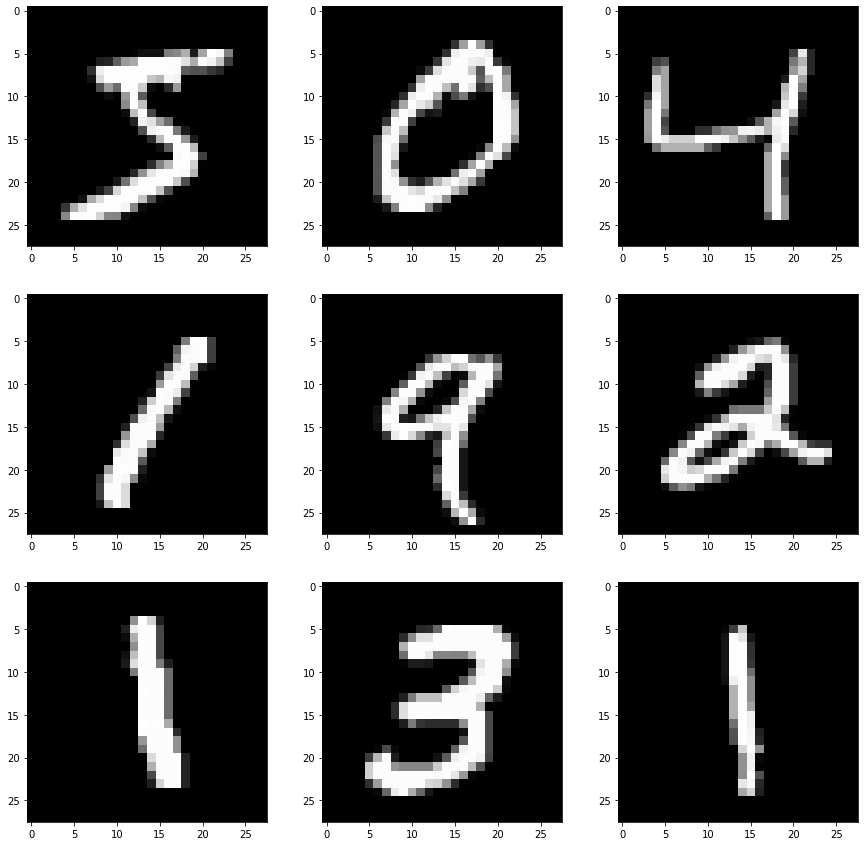

In [4]:
images, labels = iter(loader).__next__()
images = images.numpy()

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

for i in range(9):
    ax[i // 3, i % 3].imshow(np.squeeze(images[i]), cmap='gray')

In [5]:
loader = [(inputs.to(device), targets.to(device)) for inputs, targets in loader]

In [6]:
class Generator(nn.Module):
    input_size = 64

    def __init__(self):
        super(Generator, self).__init__()

        output_size = 28 ** 2
        
        self.layer0 = nn.Linear(self.input_size, output_size // 8)
        self.layer1 = nn.Linear(output_size // 8, output_size // 4)
        self.layer2 = nn.Linear(output_size // 4, output_size // 2)
        self.layer3 = nn.Linear(output_size // 2, output_size)

        self.dropoutLayer = nn.Dropout(0.2)

    def forward(self, x):
        x = functional.leaky_relu(self.layer0(x), 0.2)
        x = self.dropoutLayer(x)
        x = functional.leaky_relu(self.layer1(x), 0.2)
        x = self.dropoutLayer(x)
        x = functional.leaky_relu(self.layer2(x), 0.2)
        x = self.dropoutLayer(x)
        x = functional.tanh(self.layer3(x))

        x = (x + 1) / 2
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        input_size = 28 ** 2
        output_size = 1

        self.layer0 = nn.Linear(input_size, input_size // 4)
        self.layer1 = nn.Linear(input_size // 4, input_size // 8)
        self.layer2 = nn.Linear(input_size // 8, input_size // 16)
        self.layer3 = nn.Linear(input_size // 16, output_size)

        self.dropoutLayer = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x * 2 - 1
        x = x.view(-1, 28*28)

        x = functional.leaky_relu(self.layer0(x), 0.2)
        x = self.dropoutLayer(x)
        x = functional.leaky_relu(self.layer1(x), 0.2)
        x = self.dropoutLayer(x)
        x = functional.leaky_relu(self.layer2(x), 0.2)
        x = self.dropoutLayer(x)
        x = self.layer3(x)

        return x

In [8]:
generator = Generator().to(device)
print(generator)

discriminator = Discriminator().to(device)
print(discriminator)

Generator(
  (layer0): Linear(in_features=64, out_features=98, bias=True)
  (layer1): Linear(in_features=98, out_features=196, bias=True)
  (layer2): Linear(in_features=196, out_features=392, bias=True)
  (layer3): Linear(in_features=392, out_features=784, bias=True)
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)
Discriminator(
  (layer0): Linear(in_features=784, out_features=196, bias=True)
  (layer1): Linear(in_features=196, out_features=98, bias=True)
  (layer2): Linear(in_features=98, out_features=49, bias=True)
  (layer3): Linear(in_features=49, out_features=1, bias=True)
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


In [9]:
generator_optimizer = optim.Adam(generator.parameters(), 5 * 1e-4)
discriminator_optimizer = optim.Adam(discriminator.parameters(), 2.5 * 1e-3)

In [10]:
def real_loss(output):
    batch_size = output.size(0)
    criterion = nn.BCEWithLogitsLoss()
    return criterion(output.squeeze(), torch.ones(batch_size, device=device))

def fake_loss(output):
    batch_size = output.size(0)
    criterion = nn.BCEWithLogitsLoss()
    return criterion(output.squeeze(), torch.zeros(batch_size, device=device))

In [11]:
num_epochs = 250

discriminator_loss_history = []
generator_loss_history = []
fake_images_history = []
fake_images_history_seed = torch.from_numpy(np.random.uniform(-1, 1, size=(5, generator.input_size))).float().to(device)

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    i = 0
    for real_images, _ in loader:
        batch_size = real_images.size(0)
        i += 1
        
        # Train discriminator
        discriminator_optimizer.zero_grad()

        discriminator_predictions_real = discriminator(real_images)
        discriminator_predictions_real = discriminator_predictions_real
        real_loss_value = real_loss(discriminator_predictions_real)

        generator_seed = np.random.uniform(-1, 1, size=(batch_size, generator.input_size))
        generator_seed = torch.from_numpy(generator_seed).float().to(device)
        fake_images = generator(generator_seed)

        discriminator_predictions_fake = discriminator(fake_images)
        fake_loss_value = fake_loss(discriminator_predictions_fake)
        
        discriminator_loss = real_loss_value + fake_loss_value
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        # Train generator
        generator_optimizer.zero_grad()
        
        generator_seed = torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, generator.input_size))).float().to(device)
        fake_images = generator(generator_seed)

        discriminator_predictions_fake = discriminator(fake_images)
        generator_loss = real_loss(discriminator_predictions_fake)
        generator_loss.backward()
        generator_optimizer.step()

        if i % 100 == 0:
            print(f'Epoch: {epoch} \t real loss: {"{:.4f}".format(real_loss_value)} \t fake loss: {"{:.4f}".format(fake_loss_value)} \t discriminator loss: {"{:.4f}".format(discriminator_loss)} \t generator_loss: {"{:.4f}".format(generator_loss)}')

    discriminator_loss_history.append(discriminator_loss.cpu().detach().numpy())
    generator_loss_history.append(generator_loss.detach().cpu().numpy())
    
    generator.eval()
    fake_images = generator(fake_images_history_seed)
    fake_images = [i.reshape(28, 28).cpu().detach().numpy() for i in fake_images]
    fake_images_history.append(fake_images)

Epoch: 0 	 real loss: 0.1764 	 fake loss: 0.6248 	 discriminator loss: 0.8012 	 generator_loss: 0.9014
Epoch: 0 	 real loss: 0.0056 	 fake loss: 1.1371 	 discriminator loss: 1.1427 	 generator_loss: 0.4764
Epoch: 0 	 real loss: 0.4559 	 fake loss: 0.9201 	 discriminator loss: 1.3760 	 generator_loss: 3.1256
Epoch: 0 	 real loss: 0.2406 	 fake loss: 1.2088 	 discriminator loss: 1.4494 	 generator_loss: 0.9931
Epoch: 0 	 real loss: 0.5379 	 fake loss: 0.3585 	 discriminator loss: 0.8964 	 generator_loss: 2.7430
Epoch: 0 	 real loss: 0.3173 	 fake loss: 1.2220 	 discriminator loss: 1.5394 	 generator_loss: 1.9338
Epoch: 0 	 real loss: 1.1177 	 fake loss: 0.6571 	 discriminator loss: 1.7748 	 generator_loss: 1.2923
Epoch: 0 	 real loss: 0.4488 	 fake loss: 0.9352 	 discriminator loss: 1.3840 	 generator_loss: 5.2713
Epoch: 0 	 real loss: 1.0905 	 fake loss: 0.6969 	 discriminator loss: 1.7874 	 generator_loss: 0.9253
Epoch: 1 	 real loss: 0.1747 	 fake loss: 0.0637 	 discriminator loss: 0.

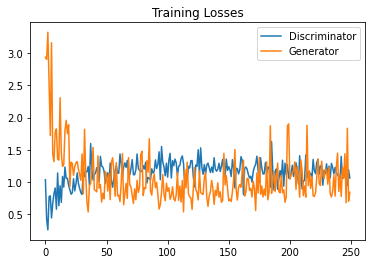

In [12]:
plt.plot(discriminator_loss_history, label='Discriminator')
plt.plot(generator_loss_history, label='Generator')
plt.title("Training Losses")
plt.legend()

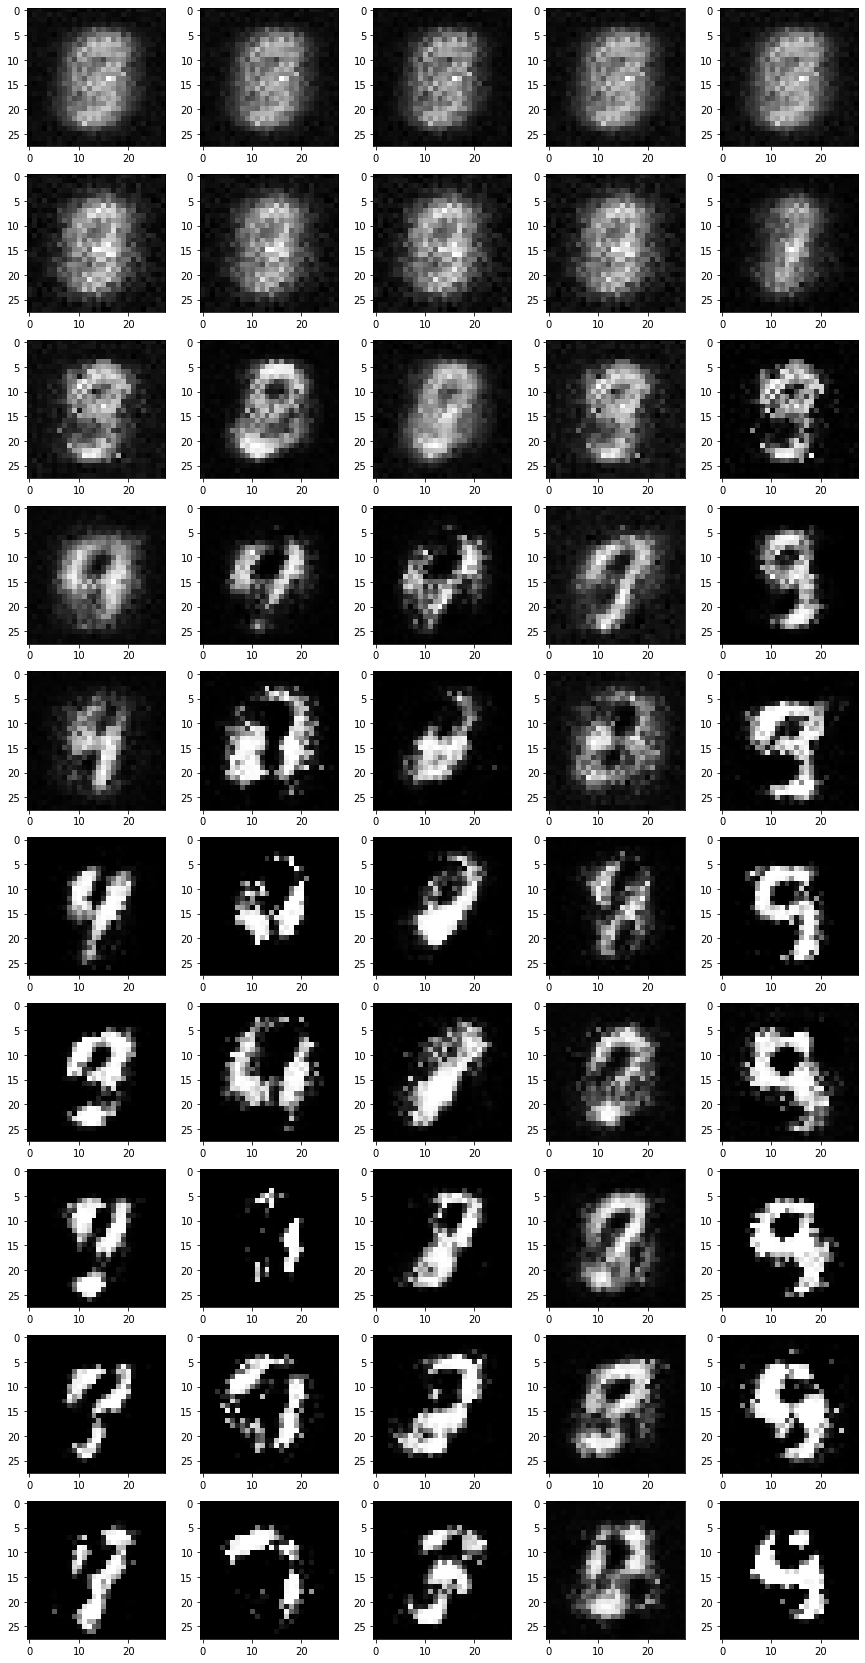

In [18]:
fig, ax = plt.subplots(10, len(fake_images_history[0]))
fig.set_size_inches(15, 30)

for epoch in range(10):
    for i in range(len(fake_images_history[epoch])):
        ax[epoch, i].imshow(np.squeeze(fake_images_history[epoch][i]), cmap='gray')

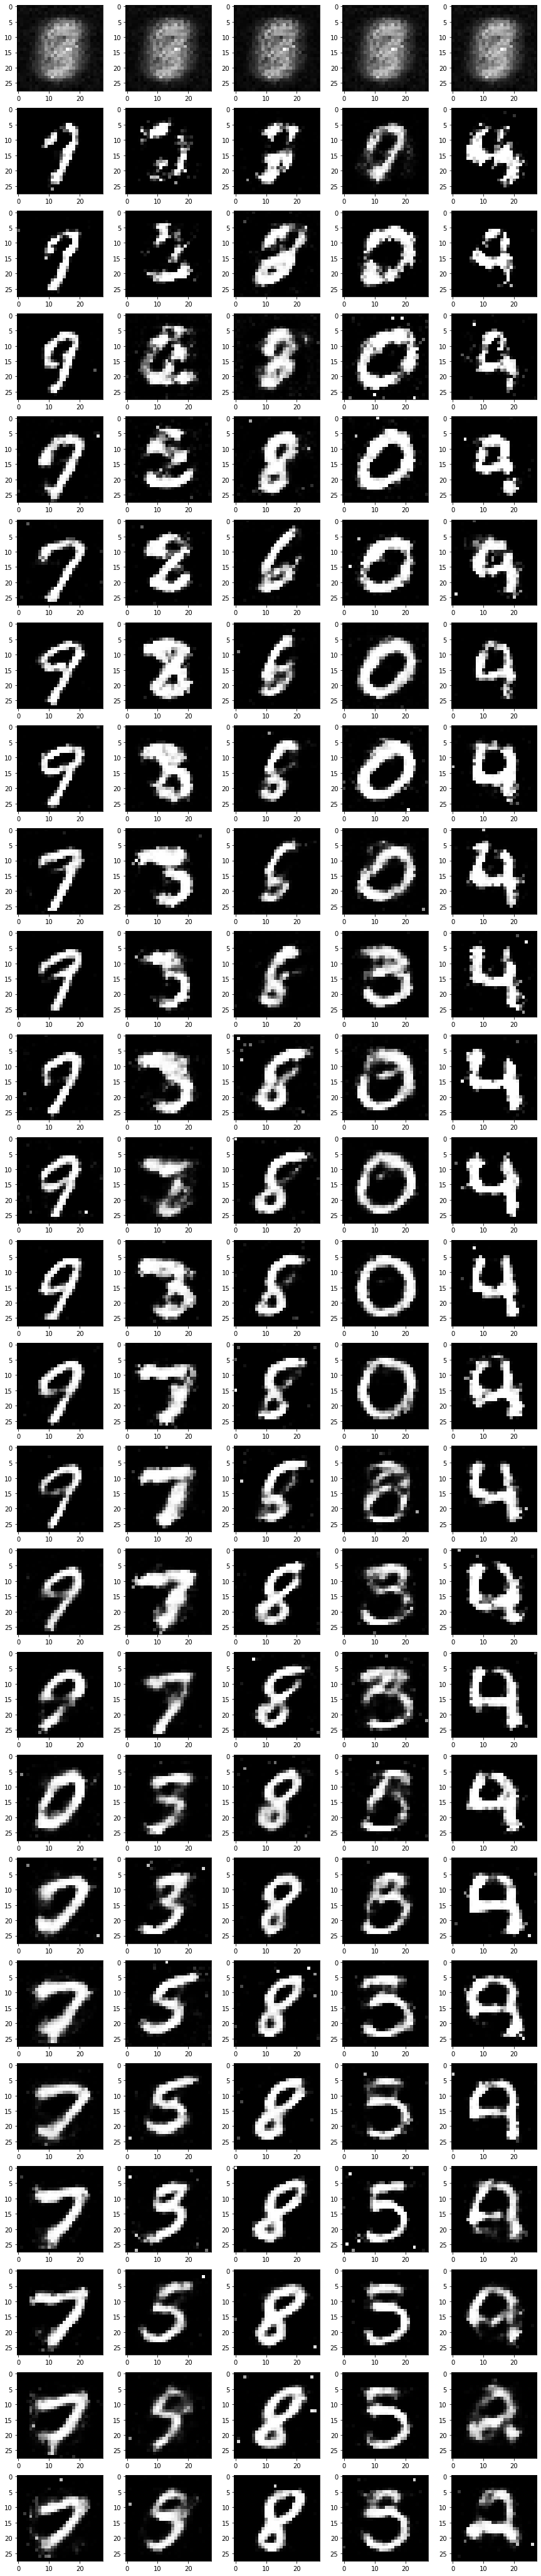

In [21]:
fake_images_history_short = [i for (index, i) in zip(range(len(fake_images_history)), fake_images_history) if index % 10 == 0]

fig, ax = plt.subplots(len(fake_images_history_short), len(fake_images_history_short[0]))
fig.set_size_inches(15, 3 * len(fake_images_history_short))

for epoch in range(len(fake_images_history_short)):
    for i in range(len(fake_images_history_short[epoch])):
        ax[epoch, i].imshow(np.squeeze(fake_images_history_short[epoch][i]), cmap='gray')